# Advanced Features of ML Project Starter

This notebook demonstrates more advanced usage of our ML project structure, including cross-validation, hyperparameter tuning, and feature importance analysis.

## 1. Setup and Imports

In [ ]:
import sys
sys.path.append('..')

from src.preprocess import DataPreprocessor
from src.model import MLModel
from src.evaluate import ModelEvaluator
from utils.helpers import validate_dataframe, safe_file_path, remove_outliers, encode_categorical

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns



## 2. Load and Explore Data

In [11]:
# Load breast cancer dataset
cancer = load_breast_cancer()
data = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data['target'] = cancer.target

# Validate the dataset structure\n",
required_cols = list(cancer.feature_names) + ['target']
numeric_cols = list(cancer.feature_names)
is_valid, message = validate_dataframe(data, required_cols, numeric_cols)
print('Data validation:', message)

print('Dataset shape:', data.shape)
print('\nFeature names:', list(cancer.feature_names))
print('\nClass distribution:')
print(data['target'].value_counts())

Data validation: Validation successful
Dataset shape: (569, 31)

Feature names: [np.str_('mean radius'), np.str_('mean texture'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('mean smoothness'), np.str_('mean compactness'), np.str_('mean concavity'), np.str_('mean concave points'), np.str_('mean symmetry'), np.str_('mean fractal dimension'), np.str_('radius error'), np.str_('texture error'), np.str_('perimeter error'), np.str_('area error'), np.str_('smoothness error'), np.str_('compactness error'), np.str_('concavity error'), np.str_('concave points error'), np.str_('symmetry error'), np.str_('fractal dimension error'), np.str_('worst radius'), np.str_('worst texture'), np.str_('worst perimeter'), np.str_('worst area'), np.str_('worst smoothness'), np.str_('worst compactness'), np.str_('worst concavity'), np.str_('worst concave points'), np.str_('worst symmetry'), np.str_('worst fractal dimension')]

Class distribution:
target
1    357
0    212
Name: count, dtype: int64


## 3. Data Preprocessing and Visualization

In [3]:
# Remove outliers from numeric features
print('Original data shape:', data.shape)
data_clean = remove_outliers(data, numeric_cols, n_std=3.0)
print('Data shape after outlier removal:', data_clean.shape)

# Create some categorical features for demonstration
data_clean['size_category'] = pd.qcut(data_clean['mean radius'], q=3, labels=['small', 'medium', 'large'])
data_clean['texture_category'] = pd.qcut(data_clean['mean texture'], q=3, labels=['smooth', 'medium', 'rough'])

# Encode categorical variables
categorical_cols = ['size_category', 'texture_category']
data_encoded, encoding_map = encode_categorical(data_clean, categorical_cols, method='onehot')

print('\nEncoding mappings:')
for col, mapping in encoding_map.items():
    print(f'{col}: {mapping}')
    print('\nFinal data shape:', data_encoded.shape)

Original data shape: (569, 31)
Data shape after outlier removal: (495, 31)

Encoding mappings:
size_category: ['size_category_small', 'size_category_medium', 'size_category_large']

Final data shape: (495, 37)
texture_category: ['texture_category_smooth', 'texture_category_medium', 'texture_category_rough']

Final data shape: (495, 37)


/home/kerod/Documents/10x_starter/ModularOOPStarter/notebooks/../utils/helpers.py:117: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[z_scores < n_std]
/home/kerod/Documents/10x_starter/ModularOOPStarter/notebooks/../utils/helpers.py:117: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[z_scores < n_std]
/home/kerod/Documents/10x_starter/ModularOOPStarter/notebooks/../utils/helpers.py:117: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[z_scores < n_std]
/home/kerod/Documents/10x_starter/ModularOOPStarter/notebooks/../utils/helpers.py:117: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[z_scores < n_std]
/home/kerod/Documents/10x_starter/ModularOOPStarter/notebooks/../utils/helpers.py:117: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[z_s

In [4]:
# Select features and prepare data
X = data_encoded.drop('target', axis=1)
y = data_encoded['target']

# Initialize and train model
model = MLModel(model_params={
    'n_estimators': 100,
    'max_depth': 5,
    'random_state': 42
    })
    
# Perform cross-validation
cv_scores = cross_val_score(model.model, X, y, cv=5)
print('Cross-validation scores:', cv_scores)
print('Mean CV score:', cv_scores.mean())
print('CV score std:', cv_scores.std())

Cross-validation scores: [0.93939394 0.92929293 0.97979798 0.95959596 0.97979798]
Mean CV score: 0.9575757575757576
CV score std: 0.020602099044819317


In [5]:
# Create a safe path for model saving
model_path = safe_file_path('../data/models/breast_cancer_model.joblib')

# Train the model on full dataset and save
model.train(X, y)
model.save_model(model_path)
print(f'Model saved to: {model_path}')

# Save the encoding mappings for future use
encoding_path = safe_file_path('../data/models/encoding_map.joblib')
import joblib
joblib.dump(encoding_map, encoding_path)
print(f'Encoding mappings saved to: {encoding_path}')

Model saved to: ../data/models/breast_cancer_model.joblib
Encoding mappings saved to: ../data/models/encoding_map.joblib


# HyperParameter Tunning, Cross-validation, and Model Comparison

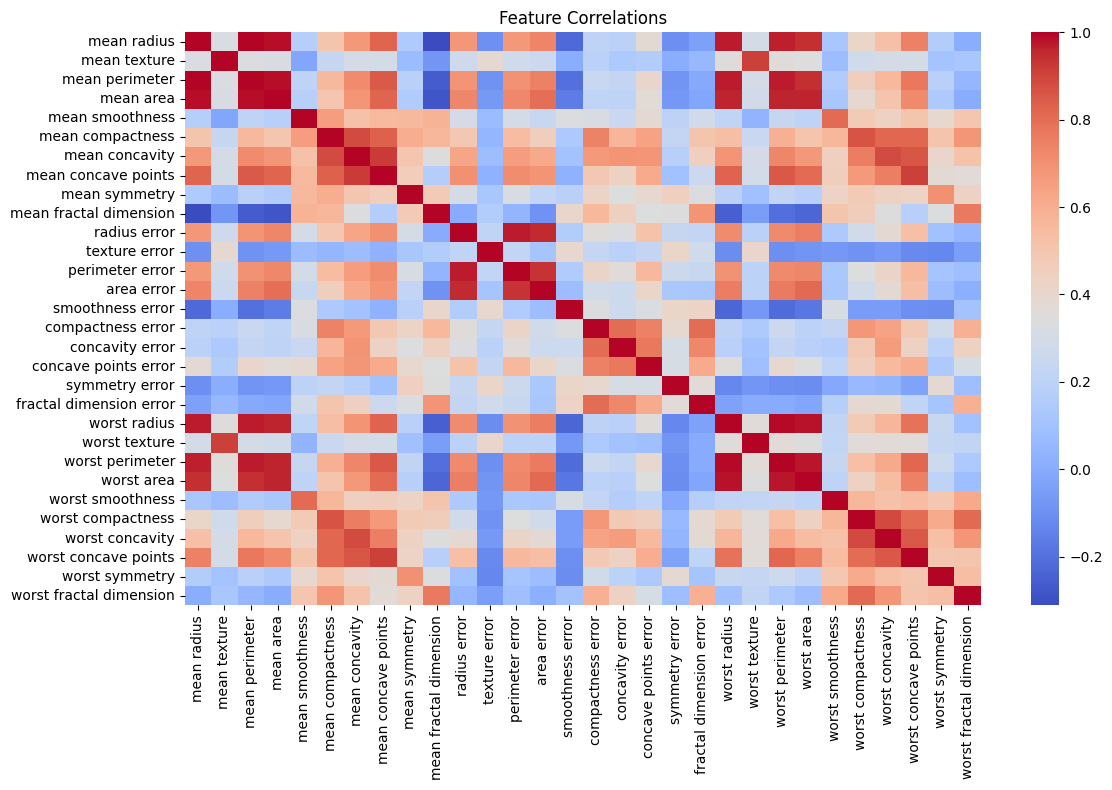

In [6]:
# Initialize preprocessor
preprocessor = DataPreprocessor()

# Process all data
X, y = preprocessor.preprocess_data(data, target_column='target')

# Visualize feature correlations
plt.figure(figsize=(12, 8))
correlation_matrix = pd.DataFrame(X, columns=cancer.feature_names).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()



## 4. Cross-Validation

In [7]:
# Initialize base model
base_model = MLModel()

# Perform 5-fold cross-validation
cv_scores = cross_val_score(base_model.model, X, y, cv=5)

print('Cross-validation scores:', cv_scores)
print('Mean CV score: {:.3f} (+/- {:.3f})'.format(
    cv_scores.mean(), cv_scores.std() * 2))

Cross-validation scores: [0.92105263 0.93859649 0.98245614 0.96491228 0.97345133]
Mean CV score: 0.956 (+/- 0.046)


## 5. Hyperparameter Tuning

In [8]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search = GridSearchCV(base_model.model, param_grid, cv=5)
grid_search.fit(X, y)

print('Best parameters:', grid_search.best_params_)
print('Best cross-validation score:', grid_search.best_score_)

Best parameters: {'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 50}
Best cross-validation score: 0.9613724576929048


## 6. Feature Importance Analysis

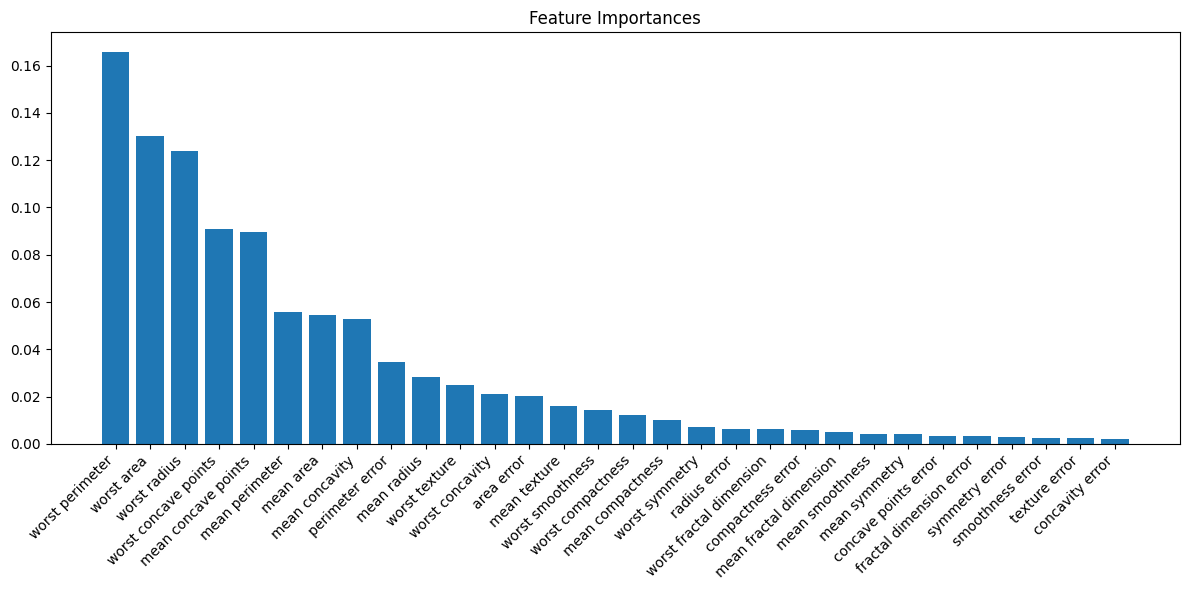

In [9]:
# Train model with best parameters
best_model = MLModel(model_params=grid_search.best_params_)
best_model.train(X, y)

# Get feature importance
importances = best_model.model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), 
          [cancer.feature_names[i] for i in indices], 
          rotation=45, 
          ha='right')
plt.tight_layout()
plt.show()

## 6. Model Comparison
Compare the performance of the base model vs the tuned model.

In [10]:
# Train the base model
base_model.train(X, y)

# Make predictions with both models
base_predictions = base_model.predict(X)
tuned_predictions = best_model.predict(X)

# Evaluate both models
evaluator = ModelEvaluator()
base_results = evaluator.evaluate_model(y, base_predictions)
tuned_results = evaluator.evaluate_model(y, tuned_predictions)

print("Base Model Performance:")
print("Accuracy:", base_results['accuracy'])
print("Tuned Model Performance:")
print("Accuracy:", tuned_results['accuracy'])

Base Model Performance:
Accuracy: 1.0
Tuned Model Performance:
Accuracy: 0.9947275922671354
